# QoL Monitor - Modeling

For the Machine Learning algorithms modeling, we decided to use the Scikit-learn toolbox due to its high acceptance in the scientific community and the consistency of its results.

## Required Imports

In [ ]:
import time
import gspread
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import auth
from google.colab import drive
from google.auth import default
import matplotlib.pyplot as plt
from pydrive.auth import GoogleAuth
from matplotlib.pyplot import figure
from pydrive.drive import GoogleDrive
from sklearn.linear_model import Lasso
from yellowbrick.features import Rank2D
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import RobustScaler
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import rank1d, rank2d
from sklearn.model_selection import GridSearchCV
from oauth2client.client import GoogleCredentials
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import prediction_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from yellowbrick.model_selection import FeatureImportances
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## Google Authentication

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
creds, _ = default()

## Getting Processed Data

In [ ]:
def getSheetAsDf(spreadsheetName, sheetName):
    spreadsheet = gc.open(spreadsheetName)
    dataset = spreadsheet.worksheet(sheetName).get_all_values()
    df = pd.DataFrame.from_records(dataset)
    header = df.iloc[0]
    df = df[1:]
    df.columns = header
    return df

In [ ]:
gc = gspread.authorize(creds)

df_physical = getSheetAsDf('QoL Monitor - Preprocessed Data', 'dataset_phy')
df_psychological = getSheetAsDf('QoL Monitor - Preprocessed Data', 'dataset_psy')

In [ ]:
df_physical.drop('id', axis=1, inplace=True)         # id
df_physical.drop('day', axis=1, inplace=True)        # day

df_psychological.drop('id', axis=1, inplace=True)         # id
df_psychological.drop('day', axis=1, inplace=True)        # day

## Stratifying our dataset

In [ ]:
# Separating predictors from the values to be predicted.
physical = df_physical.drop("phy_ref_score", axis=1)
physical_pred = df_physical["phy_ref_score"].copy()

psychological = df_psychological.drop("psy_ref_score", axis=1)
psychological_pred = df_psychological["psy_ref_score"].copy()

print('Shapes', physical.shape, physical_pred.shape, psychological.shape, psychological_pred.shape)

Shapes (1073, 102) (1073,) (1073, 102) (1073,)


## Training regression models

In [ ]:
def rmsle_cv(name, model, n_folds, X, y):
    start = time.time()
    kf = KFold(n_folds, shuffle = True, random_state = 42).get_n_splits(X.values)
    rmse = np.sqrt(-cross_val_score(model, X.values, y, scoring = "neg_mean_squared_error", cv = kf))
    mae = -cross_val_score(model, X.values, y, scoring = "neg_mean_absolute_error", cv = kf)
    r2 = cross_val_score(model, X.values, y, scoring = "r2", cv = kf)
    end = time.time()
    print(name)
    print("\t|_ MAE scores  - Mean: {:.4f}, STD: {:.4f}".format(mae.mean(), mae.std()))
    print("\t|_ RMSE scores - Mean: {:.4f}, STD: {:.4f}".format(rmse.mean(), rmse.std()))
    print("\t|_ Exec. Time (in seconds):", end - start)
    #return(rmse)

In [ ]:
def getDataset(domain):
    return {
        'physical': (physical, physical_pred),
        'psychological': (psychological, psychological_pred),
    }[domain]    

In [ ]:
def modelingRegressors(domain):
    X, y = getDataset(domain)
    print('Modeling regressors for', domain, 'domain')
    rmsle_cv("Linear Regression", LinearRegression(), 10, X, y)
    rmsle_cv("Decision Tree Regressor", DecisionTreeRegressor(), 10, X, y)
    rmsle_cv("Random Forest Regressor", RandomForestRegressor(), 10, X, y)
    
    GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
    
    rmsle_cv("GBoost Regressor", GBoost, 10, X, y)

In [ ]:
modelingRegressors('physical')

Modeling regressors for physical domain
Linear Regression
	|_ MAE scores  - Mean: 7.6242, STD: 1.9353
	|_ RMSE scores - Mean: 11.2174, STD: 5.1114
	|_ Exec. Time (in seconds): 0.9467012882232666
Decision Tree Regressor
	|_ MAE scores  - Mean: 6.3092, STD: 1.3593
	|_ RMSE scores - Mean: 9.1624, STD: 2.2736
	|_ Exec. Time (in seconds): 1.4216058254241943
Random Forest Regressor
	|_ MAE scores  - Mean: 5.1637, STD: 1.2272
	|_ RMSE scores - Mean: 7.2358, STD: 2.1394
	|_ Exec. Time (in seconds): 61.544050455093384
GBoost Regressor
	|_ MAE scores  - Mean: 5.7008, STD: 1.2025
	|_ RMSE scores - Mean: 7.6730, STD: 2.1389
	|_ Exec. Time (in seconds): 450.69812178611755


In [ ]:
modelingRegressors('psychological')

Modeling regressors for psychological domain
Linear Regression
	|_ MAE scores  - Mean: 8.1918, STD: 1.9133
	|_ RMSE scores - Mean: 10.6146, STD: 2.4728
	|_ Exec. Time (in seconds): 0.6441926956176758
Decision Tree Regressor
	|_ MAE scores  - Mean: 5.2338, STD: 1.2711
	|_ RMSE scores - Mean: 9.3811, STD: 2.0997
	|_ Exec. Time (in seconds): 0.7378833293914795
Random Forest Regressor
	|_ MAE scores  - Mean: 4.6006, STD: 1.2645
	|_ RMSE scores - Mean: 7.0427, STD: 2.2512
	|_ Exec. Time (in seconds): 30.17659592628479
GBoost Regressor
	|_ MAE scores  - Mean: 4.9707, STD: 1.3524
	|_ RMSE scores - Mean: 7.0034, STD: 2.2327
	|_ Exec. Time (in seconds): 414.71129631996155


## Grid Search

In [ ]:
def performGridSearch(domain):
    param_grid = [
        # try 12 (3×4) combinations of hyperparameters
        {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
        # then try 6 (2×3) combinations with bootstrap set as False
        {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
    ]
    X, y = getDataset(domain)
    forest_reg = RandomForestRegressor(random_state=42)
    # train across 10 folds, that's a total of (12+6)*10=180 rounds of training 
    grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(X, y)
    return grid_search

In [ ]:
grid_search_phy = performGridSearch('physical')
print("Best parameters for physical domain:", grid_search_phy.best_params_)
print("Best estimator for physical domain: ", grid_search_phy.best_estimator_)
print("Best RMSE score for physical domain:", np.sqrt(-grid_search_phy.best_score_))

Best parameters for physical domain: {'max_features': 6, 'n_estimators': 30}
Best estimator for physical domain:  RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)
Best RMSE score for physical domain: 8.068110587411667


In [ ]:
grid_search_psy = performGridSearch('psychological')
print("Best parameters for psychological domain:", grid_search_psy.best_params_)
print("Best estimator for psychological domain: ", grid_search_psy.best_params_)
print("Best RMSE score for psychological domain:", np.sqrt(-grid_search_psy.best_score_))

Best parameters for psychological domain: {'max_features': 6, 'n_estimators': 30}
Best estimator for psychological domain:  {'max_features': 6, 'n_estimators': 30}
Best RMSE score for psychological domain: 8.240263852378


## Getting feature relevance

In [ ]:
feature_importances_phy = grid_search_phy.best_estimator_.feature_importances_
sorted(zip(feature_importances_phy, df_physical.columns), reverse=True)

[(0.06458776366275285, 'weight'),
 (0.05788934314164953, 'income'),
 (0.05537080661681995, 'height'),
 (0.05229968716362453, 'calories'),
 (0.05080180223044218, 'children'),
 (0.04959345298825555, 'personalization'),
 (0.04611030872585527, 'hr_avg'),
 (0.03962205208487731, 'maritalstatus_married'),
 (0.03759277292145109, 'remsleep'),
 (0.035390219905108565, 'maritalstatus_single'),
 (0.031462101998616133, 'specificage'),
 (0.030148283754507833, 'social'),
 (0.019180289041796673, 'communication'),
 (0.018676509211538996, 'blockedcalls'),
 (0.018510740966005145, 'healthfitness'),
 (0.01610508553971326, 'videoplayerseditors'),
 (0.015543538416792653, 'gender'),
 (0.01392731309792876, 'musicaudio'),
 (0.013925258248051249, 'other'),
 (0.013498992634696587, 'familyarr'),
 (0.012765907280436866, 'awakesleep'),
 (0.012658310778866718, 'hr_min'),
 (0.012623726095129996, 'walking'),
 (0.01256390687760054, 'profession_fulltimeworker'),
 (0.012328131302580687, 'differentlocations'),
 (0.012089983

In [ ]:
feature_importances_psy = grid_search_psy.best_estimator_.feature_importances_
sorted(zip(feature_importances_psy, df_psychological.columns), reverse=True)

[(0.0964047661279916, 'income'),
 (0.07198043929107388, 'height'),
 (0.04762693034606955, 'hr_avg'),
 (0.041649024706253514, 'personalization'),
 (0.04032325463449599, 'blockedcalls'),
 (0.03785569919272723, 'weight'),
 (0.03355596780636753, 'business'),
 (0.030983182795119187, 'calories'),
 (0.030072519898700502, 'communication'),
 (0.029087057686748987, 'hr_max'),
 (0.02712446936079872, 'social'),
 (0.02575325347820097, 'musicaudio'),
 (0.025676413038303852, 'specificage'),
 (0.02415977700658549, 'videoplayerseditors'),
 (0.022641374276148058, 'hr_min'),
 (0.019949798837992045, 'maritalstatus_married'),
 (0.019729550887396242, 'lifestyle'),
 (0.019108391157890994, 'remsleep'),
 (0.018731425978330402, 'maritalstatus_single'),
 (0.018058154241326032, 'familyarr'),
 (0.017885793391197814, 'awakesleep'),
 (0.01654334994260197, 'edulevel'),
 (0.016423328086180147, 'mood'),
 (0.016059282269957967, 'steps'),
 (0.01599013475554473, 'education'),
 (0.01591867784993645, 'whatsappnotification')

## Random Forest

In [ ]:
def coerce_to_float(df):
    df.astype('float')
    return df.apply(pd.to_numeric, errors='coerce')

In [ ]:
def get_new_randomforest():
    return RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [ ]:
physical = coerce_to_float(physical)
physical_pred = coerce_to_float(physical_pred)

In [ ]:
X = physical
y = physical_pred

# spliting dataset 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

# fitting RandomForest
regressor = get_new_randomforest()
regressor.fit(X_train, y_train)

# saving the model (TODO)

# evaluation the model
prediction = regressor.predict(X_test)
mse = mean_squared_error(y_test, prediction)
rmse = mse**.5

print("MSE:", mse)
print("RMSE:", rmse)

# saving predicted value and actual value (TODO)

MSE: 44.193429951690824
RMSE: 6.647813922763695


## Recursive Feature Elimination

Feature selection refers to techniques that select a subset of the most relevant features (columns) for a dataset. Fewer features can allow machine learning algorithms to run more efficiently (less space or time complexity) and be more effective. Some machine learning algorithms can be misled by irrelevant input features, resulting in worse predictive performance.

[Reference](https://machinelearningmastery.com/rfe-feature-selection-in-python/)

In [ ]:
# Create the RFE object and compute a cross-validated score.

# The "accuracy" scoring shows the proportion of correct classifications
rfecv = RFECV(
    estimator=RandomForestRegressor(),
    step=5,
    cv=StratifiedKFold(2),
    scoring="neg_mean_squared_error",
    min_features_to_select=1,
)
rfecv.fit(X, y)

scores = np.sqrt(rfecv.grid_scores_ * -1)
labels = [x * 5 for x in list(range(1, len(rfecv.grid_scores_) + 1))]

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (RMSE)")
plt.plot(labels, scores)
plt.show()

for i in range(X.shape[1]):
	print('Column: %s, Selected %s, Rank: %.3f' % (X.columns.values.tolist()[i], rfecv.support_[i], rfecv.ranking_[i]))

## Visualization for model predictions

### Residual graphic

In [ ]:
# https://www.scikit-yb.org/en/latest/api/regressor/residuals.html
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
def buildResidualGraph(X, y, regressor, mytitle):
    # spliting dataset 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # adjusting y type to float
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    y_train.astype('float')
    y_test = y_test.apply(pd.to_numeric, errors='coerce')
    y_test.astype('float')

    figure(figsize=(8, 6), dpi=80)

    # Instantiate the visualizer
    visualizer = ResidualsPlot(regressor, title=mytitle)

    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

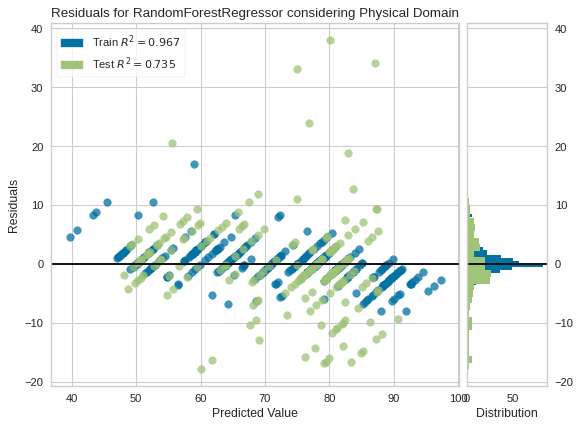

In [ ]:
# Build residual graphic for physical dataset
buildResidualGraph(physical, physical_pred, get_new_randomforest(), 'Residuals for RandomForest considering Physical Domain')

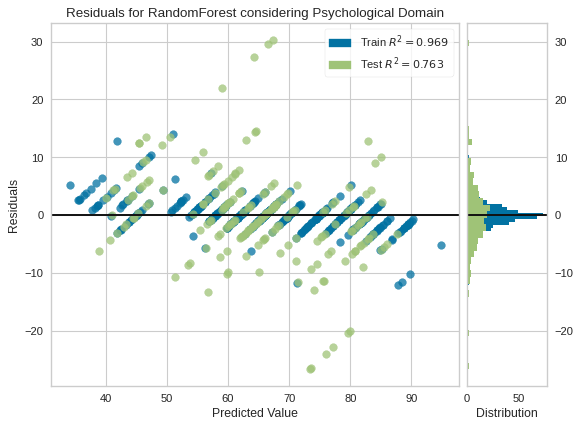

In [ ]:
# Build residual graphic for psychological dataset
buildResidualGraph(psychological, psychological_pred, get_new_randomforest(), 'Residuals for RandomForest considering Psychological Domain')

### PredictionError graphic

In [ ]:
# https://www.scikit-yb.org/en/latest/api/regressor/peplot.html
def buildPredictionErrorGraph(X, y, regressor, mytitle):
    # spliting dataset 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # adjusting y type to float
    y_train = y_train.apply(pd.to_numeric, errors='coerce')
    y_train.astype('float')
    y_test = y_test.apply(pd.to_numeric, errors='coerce')
    y_test.astype('float')

    figure(figsize=(10, 8), dpi=100)

    # Instantiate the visualizer
    visualizer = prediction_error(regressor, X_train, y_train, X_test, y_test, title=mytitle)
    # Finalize and render the figure
    visualizer.show()                 

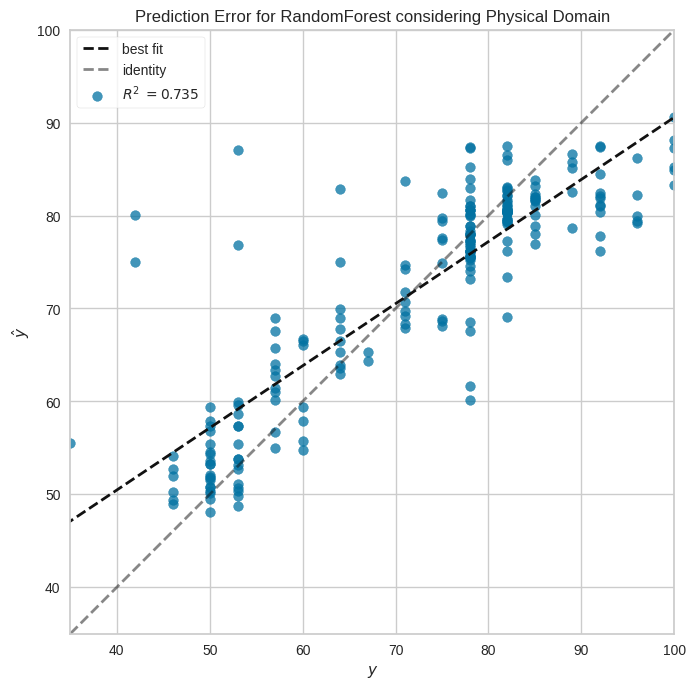

In [ ]:
# Build prediction error graphic for physical dataset
buildPredictionErrorGraph(physical, physical_pred, get_new_randomforest(), 'Prediction Error for RandomForest considering Physical Domain')

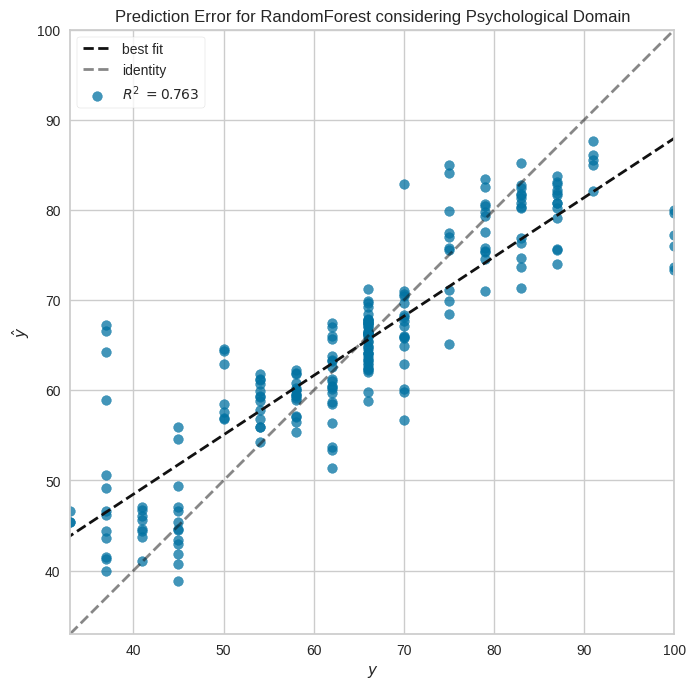

In [ ]:
# Build prediction error graphic for psychological dataset
buildPredictionErrorGraph(psychological, psychological_pred, get_new_randomforest(), 'Prediction Error for RandomForest considering Psychological Domain')

### Feature importance graphic

In [ ]:
def add_value_labels(ax, spacingH=10):
    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = rect.get_width()

        # Number of points between bar and label. Change to your liking.
        space = spacingH
        # Vertical alignment for positive values
        va = 'center'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(spacingH, 0),       # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

In [ ]:
# https://www.scikit-yb.org/en/latest/api/model_selection/importances.html
def buildFeatureImportanceGraph(X, y, regressor, mytitle):
    
    figure(figsize=(8, 6), dpi=100)
    
    viz = FeatureImportances(regressor, topn=20, title=mytitle)
    viz.fit(X, y)
    viz.finalize()
    # add_value_labels(viz.ax)

    viz.show()

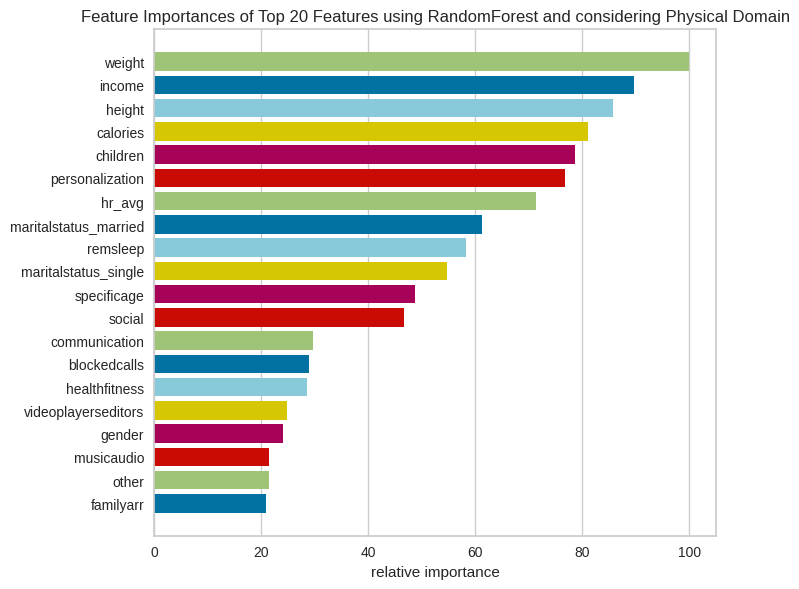

In [ ]:
# Build feature importance graphic for physical dataset
buildFeatureImportanceGraph(physical, physical_pred, get_new_randomforest(), 'Feature Importances of Top 20 Features using RandomForest and considering Physical Domain')

In [ ]:
most_relevant_features_phy = pd.DataFrame().assign(
    weight=physical['weight'], 
    income=physical['income'], 
    height=physical['height'],
    calories=physical['calories'], 
    children=physical['children'], 
    personalization=physical['personalization'],
    hr_avg=physical['hr_avg'], 
    maritalstatus_married=physical['maritalstatus_married'], 
    remsleep=physical['remsleep'],
    maritalstatus_single=physical['maritalstatus_single'], 
    physical_score=physical_pred
)

mr20_features_phy = pd.DataFrame().assign(
    weight=physical['weight'], 
    income=physical['income'], 
    height=physical['height'],
    calories=physical['calories'], 
    children=physical['children'], 
    personalization=physical['personalization'],
    hr_avg=physical['hr_avg'], 
    maritalstatus_married=physical['maritalstatus_married'], 
    remsleep=physical['remsleep'],
    maritalstatus_single=physical['maritalstatus_single'],

    specificage=physical['specificage'],
    social=physical['social'],
    communication=physical['communication'],
    blockedcalls=physical['blockedcalls'],
    healthfitness=physical['healthfitness'],
    videoplayerseditors=physical['videoplayerseditors'],
    gender=physical['gender'],
    musicaudio=physical['musicaudio'],
    other=physical['other'],
    familyarr=physical['familyarr'],

    physical_score=physical_pred
)

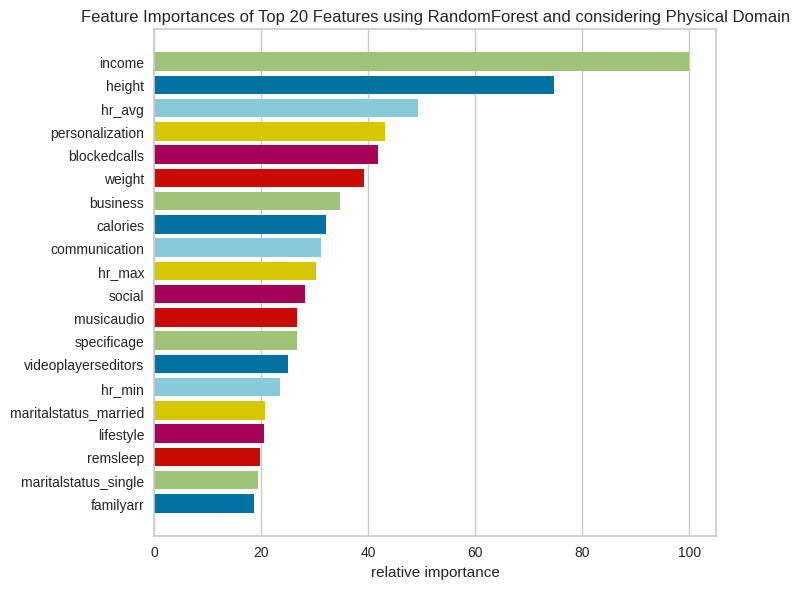

In [ ]:
# Build feature importance graphic for physical dataset
buildFeatureImportanceGraph(psychological, psychological_pred, get_new_randomforest(), 'Feature Importances of Top 20 Features using RandomForest and considering Physical Domain')

In [ ]:
most_relevant_features_psy = pd.DataFrame().assign(
    income=psychological['income'], 
    height=psychological['height'], 
    hr_avg=psychological['hr_avg'],
    personalization=psychological['personalization'], 
    blockedcalls=psychological['blockedcalls'], 
    weight=psychological['weight'],
    business=psychological['business'], 
    calories=psychological['calories'], 
    communication=psychological['communication'],
    hr_max=psychological['hr_max'], 
    psychological_score=psychological_pred
)

mr20_features_psy = pd.DataFrame().assign(
    income=psychological['income'], 
    height=psychological['height'], 
    hr_avg=psychological['hr_avg'],
    personalization=psychological['personalization'], 
    blockedcalls=psychological['blockedcalls'], 
    weight=psychological['weight'],
    business=psychological['business'], 
    calories=psychological['calories'], 
    communication=psychological['communication'],
    hr_max=psychological['hr_max'], 

    social=psychological['social'],
    musicaudio=psychological['musicaudio'],
    specificage=psychological['specificage'],
    videoplayerseditors=psychological['videoplayerseditors'],
    hr_min=psychological['hr_min'],
    maritalstatus_married=psychological['maritalstatus_married'],
    lifestyle=psychological['lifestyle'],
    remsleep=psychological['remsleep'],
    maritalstatus_single=psychological['maritalstatus_single'],
    familyarr=psychological['familyarr'],

    psychological_score=psychological_pred
)

### Correlation graphic

In [ ]:
def buildCorrelationMatrix(X, y):
    figure(figsize=(8, 6), dpi=100)

    visualizer = Rank2D(algorithm='pearson', annot=True, fmt="d")

    X = X.apply(pd.to_numeric, errors='coerce')
    X.astype('float')

    # Fit the data to the visualizer
    visualizer.fit(X, y)
    # Transform the data
    visualizer.transform(X)
    
    visualizer.finalize()

    visualizer.show()

In [ ]:
# https://realpython.com/numpy-scipy-pandas-correlation-python/
# https://support.google.com/googleplay/android-developer/answer/9859673
def buildPearsonCorrelationMatrix(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    df.astype('float')
    
    plt.figure(figsize=(12, 10), dpi=100)

    # Using Pearson Correlation
    # Pearson’s coefficient measures linear correlation
    correlation = df.corr(method='pearson')

    # creating mask
    mask = np.triu(np.ones_like(correlation))

    sns.heatmap(correlation, cmap="coolwarm", annot=True, mask=mask, fmt='.1f')

    plt.show()

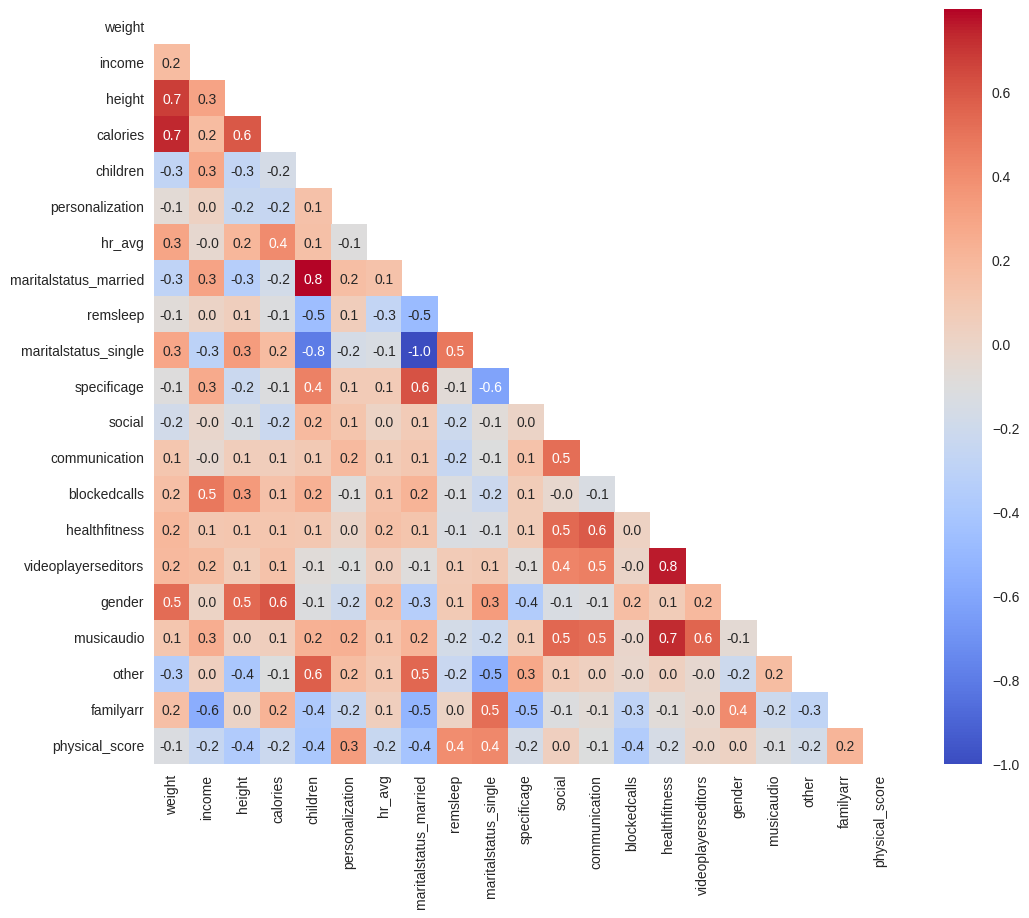

In [ ]:
buildPearsonCorrelationMatrix(mr20_features_phy)

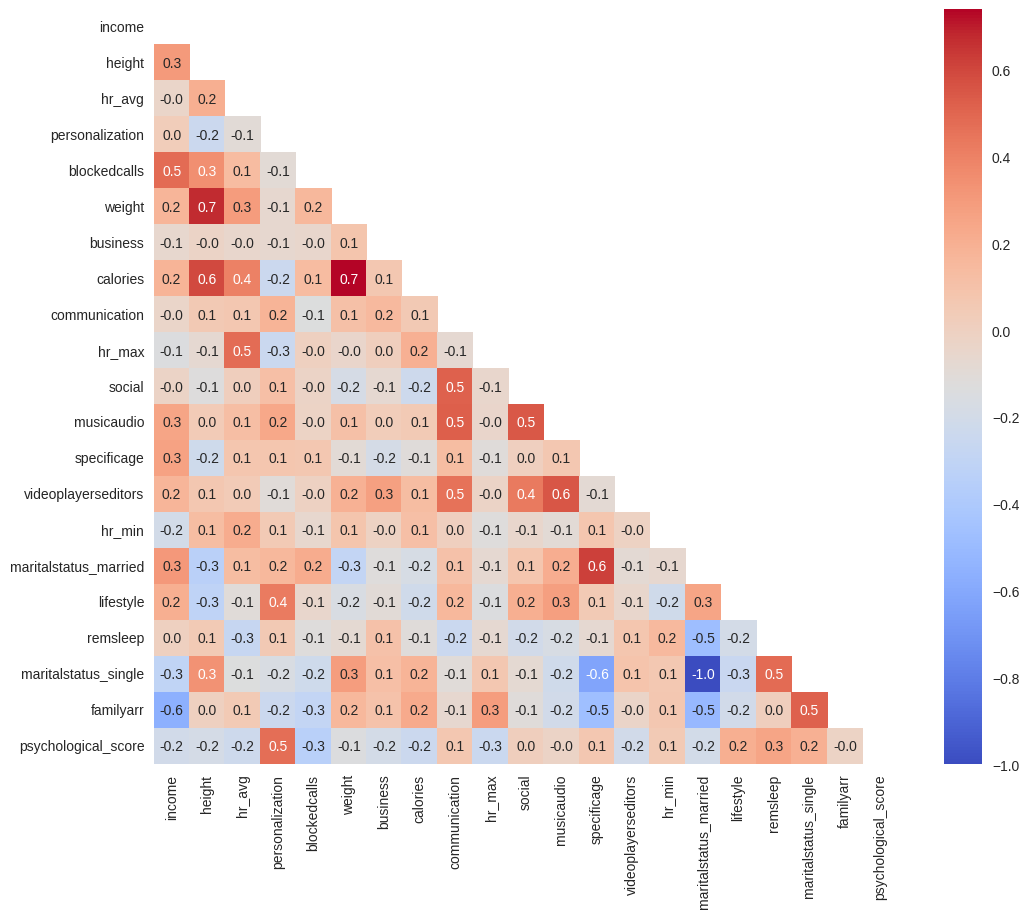

In [ ]:
buildPearsonCorrelationMatrix(mr20_features_psy)